In [6]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
#import seaborn as sns

In [6]:
from random import random
from tqdm.notebook import tqdm

In [7]:
import time
import multiprocess as mp

### Read data & preprocessing

In [4]:
df_ref = pd.read_csv('./Data/glioblastoma_BT_S2/ref.csv', index_col = 0)
df_alt = pd.read_csv('./Data/glioblastoma_BT_S2/alt.csv', index_col = 0)

In [5]:
# use multi-index for easier handling of the data
df_ref['chromosome'] = [locus.split('_')[0] for locus in df_ref.index]
df_ref['locus'] = [locus.split('_')[1] for locus in df_ref.index]
df_ref = df_ref.set_index(['chromosome', 'locus'])

df_alt['chromosome'] = [locus.split('_')[0] for locus in df_alt.index]
df_alt['locus'] = [locus.split('_')[1] for locus in df_alt.index]
df_alt = df_alt.set_index(['chromosome', 'locus'])

### Utility functions

### Data generator

### Mutation detection

In [6]:
from mutation_detection import *
from LOH_detection import *

In [7]:
ref = df_ref.to_numpy(dtype = float)
alt = df_alt.to_numpy(dtype = float)
coverages = ref.flatten() + alt.flatten()

In [8]:
ref.shape

(16153, 1168)

In [14]:
(1 - 1/(2*1168 - 2)**2) ** 16153

0.9970392086221009

In [8]:
get_composition_priors(10, genotype_freq = {'R': 1/3, 'H': 1/3, 'A': 1/3}, mutation_rate = 0.25)

array([-1.37756068, -3.097773  , -4.3605863 , -4.90861448, -5.20414742,
       -5.34459926, -5.35256743, -5.20710746, -4.81257143, -3.70868208,
       -1.35180819, -3.70868208, -4.81257143, -5.20710746, -5.35256743,
       -5.34459926, -5.20414742, -4.90861448, -4.3605863 , -3.097773  ,
       -1.37756068])

In [9]:
start_time = time.time()
posteriors = get_posteriors(ref, alt, n_threads = 6)
print('Runtime:', (time.time() - start_time) / 60, 'min')
pd.DataFrame(posteriors, columns = ['R', 'H', 'A', 'RH', 'HA'], index = df_ref.index).to_csv('./posteriors.csv')

Runtime: 33.48343937397003 min


In [8]:
df_posteriors = pd.read_csv('./posteriors.csv', index_col = (0,1))
posteriors = df_posteriors.to_numpy()

In [9]:
mutated_idx, mut_type_idx = np.where(posteriors[:,3:] > 1 - 1 / posteriors.shape[0])
n_mutated = mutated_idx.size
homos = [['R', 'A'][i] for i in mut_type_idx]

In [11]:
corr_posteriors = get_corr_posteriors(ref[mutated_idx,:], alt[mutated_idx,:], homos, corr_prior = 1/2) 

  0%|          | 0/11303 [00:00<?, ?it/s]

  0%|          | 0/11304 [00:00<?, ?it/s]

In [22]:
pd.DataFrame(data = {'correlation posterior': np.concatenate((corr_posteriors, [0])), 'mutation type': ['H' + h for h in homos]}, 
             index = df_posteriors.index[mutated_idx]).to_csv('./corr_posteriors.csv')

### Tree inference

In [4]:
df_corr = pd.read_csv('./corr_posteriors.csv', index_col = (0,1))
corr_posteriors = df_corr['correlation posterior'].to_numpy()

In [6]:
df_corr

correlation posterior mutation type
chromosome locus                                         
chr1       631861             8.932958e-187            HR
           634233              1.000000e+00            HR
           634238              1.000000e+00            HR
           634243             8.163297e-139            HR
           945084             8.947311e-282            HR
...                                     ...           ...
chrX       154778966           6.332194e-02            HR
           154801469           1.441177e-04            HR
           155051675           1.000930e-02            HR
           155061890           2.339600e-02            HR
           155943589           0.000000e+00            HR

[11304 rows x 2 columns]

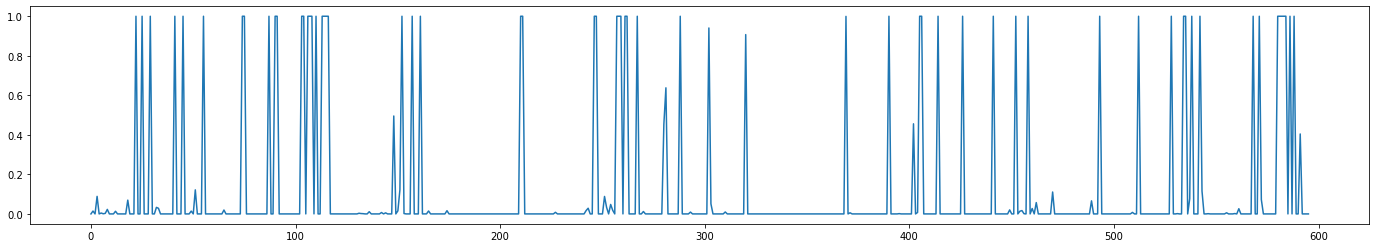

In [29]:
chromosome = 'chr12'
plt.figure(figsize = (24,4))
plt.plot(corr_posteriors[df_corr.index.get_level_values(0) == chromosome])
plt.show()

In [ ]:
from tree import *

In [12]:
a = np.random.randint(10, size = 1000)

In [17]:
%timeit np.where(a == 5)

2.05 µs ± 19.1 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


### SVD Imputation

In [ ]:
# X: data matrix in which rows (dimension 0) are samples and columns (dimension 1) are features
def mean_impute(X): 
    X_imputed = X.copy() 
    for i in range(X.shape[1]): 
        feature = X[:,i] 
        mean = np.nanmean(feature) # take mean of the feature, ignoring NaN
        if np.isnan(mean): 
            print('[Mean Imputation] WARNING: Empty feature at column %d.'%i) 
        nan_indices = np.where(np.isnan(feature))[0] 
        X_imputed[nan_indices,i] = mean 
    return X_imputed 


def zero_impute(X): 
    X_imputed = X.copy()
    X_imputed[np.isnan(X)] = 0
    return X_imputed
    

def svd_impute(X, rank = None, tol = 0.1, max_iter = 100):
    if rank is None: 
        rank = min(X.shape) // 2
    
    nan_indices = np.where(np.isnan(X))
    X_imputed = zero_impute(X) #initialise all nan entries with the a mean imputation
    
    for i in tqdm(range(max_iter)):
        X_old = X_imputed.copy()
        L,D,R = np.linalg.svd(X_imputed)
        X_approx = L[:,:rank] @ np.diag(D[:rank]) @ R[:rank,:] #rank r approximation of X_imputed
        X_imputed[nan_indices] = X_approx[nan_indices]
        fnorm = np.linalg.norm(X_old - X_imputed, ord="fro")
        if fnorm < tol:
            print('[SVD Imputation]: Converged after %d iterations.'%(i+1))
            print('Frobenius norm:', fnorm)
            break
        if (i+1) >= max_iter:
            print('[SVD Imputation]: Maximum number (%d) of iterations reached.'%(i+1))
            print('Frobenius norm:', fnorm)
    
    return X_imputed

In [ ]:
ref.shape

In [ ]:
np.sum(alt > 5, axis = 1)

In [ ]:
with sns.axes_style("darkgrid"):
    plt.figure(figsize = (16, 12))
    plt.plot(np.sum(alt > 16, axis = 1))
    plt.show()

In [ ]:
for i in range(ref.shape[0]): 
    for j in range(ref.shape[1]): 
        if ref[i,j] == 0 and alt[i,j] == 0:
            ref[i,j] = np.nan
            alt[i,j] = np.nan

In [ ]:
X = np.concatenate([ref, alt], axis = 1)
X_imputed = svd_impute(X, rank = 5)

In [ ]:
X_imputed.shape

In [ ]:
ref_imputed = X_imputed[:,:ref.shape[1]]
alt_imputed = X_imputed[:,ref.shape[1]:]

In [ ]:
ref_proportion = (ref_imputed + 1) / (ref_imputed + alt_imputed + 2)

plt.figure(figsize=(24,16))
plt.imshow(ref_proportion.T, cmap = 'viridis', vmin = 0., vmax = 1.) 
# "viridis": yellow for 1, purple for 0, green/blue for 0.5 (https://matplotlib.org/3.5.1/tutorials/colors/colormaps.html)
plt.xlabel('locus index', fontsize = 17)
plt.ylabel('cell index', fontsize = 17)
plt.show()

### HMM

In [ ]:
# I: initial probability
# T: transition probability (including the begin state)
# E: emission probability
# X: observation
def viterbi(I, T, E, X):
    length = X.shape[0]
    n_states = X.shape[1]
    v = np.zeros((length, n_states)) # v[j, k] = max joint probability having k at step j and emission X[i]
    
    v[0,:] = np.array([I[i] * E(i, X[0]) for i in range(n_states)])
    for j in range(1, length):
        for k in range(n_states):
            v[j,k] = E(k, X[j]) * np.max([v[j-1,l] * T(l,k) for l in range(n_states)]) # l: assumed state of previous step
    
    best_path = np.argmax(v, axis = 1)
    
    return best_path, v[-1, best_path[-1]] # second return is the max joint probability

In [ ]:
transition_matrix = np.array([[0.9, 0.1],
                              [0.5, 0.5]])
def T(pre, post):
    return transition_matrix[pre, post]

In [ ]:
def E(state, obs, f = 0.7, omega = 10):
    n_ref = obs[0]
    coverage = np.sum(obs)
    if state == 1: # normal (heterozygous)
        alpha = (1/2 - 2/3 * f) / omega
        beta = omega - alpha
    elif state == 2: # LOH
        alpha = f * omega
        beta = omega - alpha
    else: 
        print('\n ERROR: invalid state \n')
        return
    
    return betabinom.pmf(n_ref, coverage, alpha, beta)

In [ ]:
X = np.stack((np.array(df_ref.loc['chr1',:])[0,:], np.array(df_alt.loc['chr1',:])[0,:])).T
X